In [106]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
api = wandb.Api()
sweep = api.sweep("omar-s/url_benchmark/fq1gk59g")

In [84]:
dfs = []
metrics = ['eval/frame', 'eval/episode_reward']
for run in sweep.runs:
    assert run.state == 'finished'
    config = run.config
    num_data = config['num_train_frames'] // config['eval_every_frames'] + 1
    run_df =  run.history()[run.history()['eval/episode_reward'].notna()][metrics].reset_index(drop=True)
    assert len(run_df) == num_data
    config = pd.json_normalize(config, sep='.')
    for k, v in config.items():
        run_df[k] = v[0]
    dfs.append(run_df)
df = pd.concat(dfs)

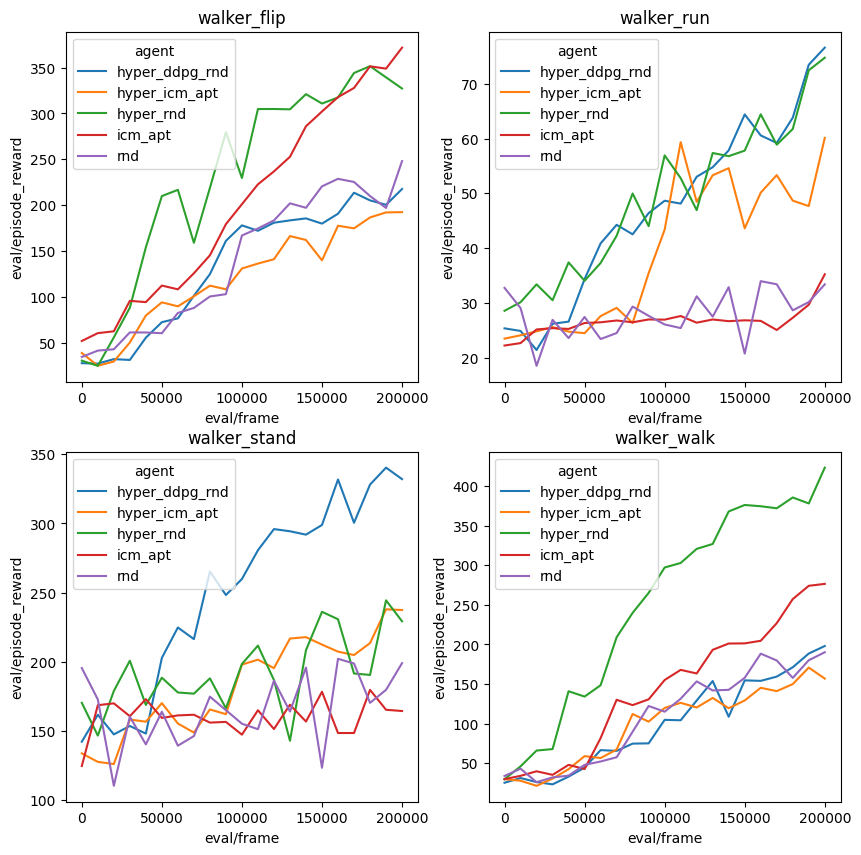

In [130]:
hue_order = sorted(df['agent'].unique().tolist())
tasks = sorted(df['task'].unique().tolist())
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, task in enumerate(tasks):
    row = i // 2
    col = i - row*2
    sns.lineplot(ax=ax[row, col], data=df[df['task'] == task], x='eval/frame', y='eval/episode_reward', hue='agent', hue_order=hue_order, errorbar=None)
    ax[row, col].set_title(task)